# 目的
遺伝子学的分類に基づいた、再発の2値分類を実施する。  

In [1]:
# 基本的なライブラリ
import os
from tqdm import tqdm
import warnings

warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd

pd.set_option("display.max_columns", 50)

import matplotlib.pyplot as plt

%matplotlib inline

# パイプライン（imblearn）
from imblearn.pipeline import Pipeline
from imblearn import FunctionSampler

# モデル
from sksurv.ensemble import (
    ComponentwiseGradientBoostingSurvivalAnalysis,
    GradientBoostingSurvivalAnalysis,
    RandomSurvivalForest,
    ExtraSurvivalTrees,
)
from sksurv.svm import FastKernelSurvivalSVM
from sksurv.linear_model import IPCRidge


# 評価指標
from sksurv.metrics import (
    concordance_index_ipcw,
    cumulative_dynamic_auc,
    integrated_brier_score,
)

import config
import functions

SEED = config.SEED
TARGET_NAME = ["RFS_STATUS", "RFS_MONTHS"]
functions.fix_seed(SEED)


df_recurrenced = pd.read_pickle(
    config.INTERIM_PREPROCESSED_RECURRENCE_DIR + "/df_recurrenced4numeric.pkl"
)

# データ全体での予測モデル検証

## ベースモデルの学習結果

各特徴量選択されたdfを用いて基本的な2値分類モデルを学習する

In [2]:
def save_model_pipeline(
    pipeline: callable,
    val_step: str,
    save_file_path: str = ".",
):
    # fit後pipelineの保存
    pipeline_path = "{0}/{1}".format(save_file_path, val_step)
    functions.make_dir(pipeline_path)
    functions.pickle_dump(pipeline, "{0}/model_pipeline.pkl".format(pipeline_path))

In [3]:
def exists_pipeline(path: str) -> bool:
    return os.path.exists(path)

In [4]:
def plot_step_funcs(funcs, label=None, xlabel=None, ylabel=None):
    for fn in funcs:
        plt.step(fn.x, fn(fn.x), where="post", label=label)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xlim(0, 250)
    plt.ylim(0, 1)
    plt.grid(True)
    plt.legend()

In [72]:
def validate_model(
    model_order: dict = {"original_data": []},
    val_step="val_set",
    input_data_path: str = None,
    output_pipe_path: str = None,
    is_fitted: bool = False,
):
    try:
        _X_train = pd.read_pickle(
            "{0}/{1}/train/X.pkl".format(input_data_path, val_step)
        )
        _y_train = pd.read_pickle(
            "{0}/{1}/train/y.pkl".format(input_data_path, val_step)
        ).to_records(index=False)
        _X_test = pd.read_pickle("{0}/{1}/test/X.pkl".format(input_data_path, val_step))
        _y_test = pd.read_pickle(
            "{0}/{1}/test/y.pkl".format(input_data_path, val_step)
        ).to_records(index=False)
    except:
        print("data pkl file dose not exist")
        return pd.DataFrame()

    # display(_X_train.shape, _y_train.shape)
    # display(_X_test.shape, _y_test.shape)
    if _X_train.shape[0] < 20:
        return

    pipeline_path = "{0}/{1}".format(output_pipe_path, val_step)
    if exists_pipeline(pipeline_path) and is_fitted:
        # 学習済みパイプラインの使用
        _model_pipeline = functions.pickle_load(
            "{0}/model_pipeline.pkl".format(pipeline_path)
        )
    else:
        # パイプラインの学習の実施
        _model_pipeline = Pipeline(steps=model_order)
        _model_pipeline.fit(_X_train, _y_train)
    _estimator = _model_pipeline[-1]

    # c-index
    _train_score = _estimator.score(_X_train, _y_train)
    _test_score = _estimator.score(_X_test, _y_test)

    _risk_test = _model_pipeline.predict(_X_test)
    print(_risk_test)
    va_times = np.arange(
        pd.DataFrame(_y_test).RFS_MONTHS.min(),
        pd.DataFrame(_y_test).RFS_MONTHS.max(),
        1,
    )
    # cumulative/dynamic auc
    _cph_auc, _cph_mean_auc = cumulative_dynamic_auc(
        _y_train, _y_test, _risk_test, va_times
    )
    print(_cph_mean_auc)

    # 累積AUCの表示
    plt.subplot(1, 1, 1)
    plt.plot(va_times, _cph_auc, label=_estimator.__class__.__name__)
    plt.xlabel("months from surgery")
    plt.ylabel("time-dependent AUC")
    plt.xlim(0, 250)
    plt.ylim(0, 1)
    plt.grid(True)
    plt.legend()

    """
    # plot survival funcs
    _surv_funcs_test = _model_pipeline.predict_survival_function(
        _X_test[0].reshape(1, -1)
    )
    plt.subplot(1, 3, 2)
    plot_step_funcs(
        funcs=_surv_funcs_test,
        label=_estimator.__class__.__name__,
        xlabel="months from surgery",
        ylabel="surv rate",
    )

    # テストデータ患者のハザード率のプロット
    _chf_funcs_test = _estimator.predict_cumulative_hazard_function(
        _X_test[0].reshape(1, -1)
    )
    plt.subplot(1, 3, 3)
    plot_step_funcs(
        funcs=_chf_funcs_test,
        label=_estimator.__class__.__name__,
        xlabel="months from surgery",
        ylabel="hazard rate",
    )
    """

    df_score = pd.DataFrame(
        [_train_score, _test_score, _cph_mean_auc],
        index=[
            "train c-index",
            "test c-index",
            "AUC mean",
        ],  # "Integrated Brier Score"],
        columns=[_estimator.__class__.__name__],
    ).round(3)

    if output_pipe_path:
        save_model_pipeline(
            pipeline=_model_pipeline,
            val_step=val_step,
            save_file_path=output_pipe_path,
        )
    return df_score

In [73]:
def loop_exec():
    # 層別化する特徴量
    subgroup_columns = [
        "CLAUDIN_SUBTYPE",
        # "THREEGENE",
    ]
    # 遺伝子発現量以外の特徴量を削除
    drop_columns = [
        "CLAUDIN_SUBTYPE",
        "THREEGENE",
    ]

    val_step = "test_set"

    for subgroup_column in subgroup_columns:  # 各サブグループへの適用
        for subgroup in df_recurrenced[subgroup_column].unique():  # サブグループの要素毎への適用
            # print("subgroup: ", subgroup)
            # init each loop
            plt.figure(figsize=(6, 6))
            df_scores = pd.DataFrame(
                index=["train c-index", "test c-index", "AUC mean"]
            )

            for model_order_dict in model_order_dicts:
                input_data_path = "./{0}/{1}/{2}/{3}".format(
                    config.INTERIM_PREPROCESSED_RECURRENCE_DIR,
                    subgroup_column,
                    subgroup,
                    model_order_dict["preprocess_name"],
                )
                output_pipe_path = "./{0}/{1}/{2}/{3}/{4}".format(
                    config.INTERIM_MODELS_RECURRENCE_DIR,
                    subgroup_column,
                    subgroup,
                    model_order_dict["preprocess_name"],
                    model_order_dict["model_name"],
                )
                df_score = validate_model(
                    model_order=model_order_dict["model_order"],
                    val_step=val_step,
                    input_data_path=input_data_path,
                    output_pipe_path=output_pipe_path,
                    is_fitted=False,
                )
                df_scores = pd.merge(
                    df_scores, df_score, right_index=True, left_index=True
                )

            try:
                output_result_path = "./{0}/{1}/{2}/{3}".format(
                    config.INTERIM_MODELS_RECURRENCE_DIR,
                    subgroup_column,
                    subgroup,
                    model_order_dict["preprocess_name"],
                )
                functions.make_dir(output_result_path)
                df_scores.to_csv(output_result_path + "/result.csv")
            except:
                pass

            output_fig_path = "./{0}/{1}/{2}/{3}".format(
                config.FIGURES_MODELS_RECURRENCE_DIR,
                subgroup_column,
                subgroup,
                model_order_dict["preprocess_name"],
            )
            functions.make_dir(output_fig_path)
            # plt.close()
            plt.title(subgroup)
            plt.savefig(output_fig_path + "/auc.png")
            plt.show();

  0%|                                                                                             | 0/1 [00:00<?, ?it/s]

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
25
predict
[-0.0564412   0.06125336 -0.17015472  0.02684609 -0.16231319  0.11964107
 -0.27032482 -0.19418064  0.10677594 -0.11365772  0.05099538 -0.11218666
  0.03789873  0.13345669  0.2919291  -0.10335281 -0.09962489 -0.18440248
  0.14306587  0.09688016]
0.5344053707227453
predict
[-0.55392606 -2.17307399 -2.14325501 -1.71062237 -0.54244551 -0.71917419
 -2.11066187 -0.15097089 -2.64390978 -4.19852955 -1.66766981 -2.0720422
  3.18098817 -1.31175369  2.68214045 -3.00630389 -1.14435448 -0.53460374
  0.82514976  0.38638684]
0.6116986112883163
predict
[10.05663741 12.90198956  6.35037235  9.5236492  15.26722137 12.4833065
  5.77081905 10.39831512 11.13702434 11.33501793  8.16491282  9.4019888
 14.91927234 11.52423374 14.84261864 11.85790988 11.31057794  9.27792934
 17.64139142 12.58468426]
0.5374948972636966
predict
[10.89329973 11.82944773 10.51970795 11.44337023 11.6475133  11.57629058
 1

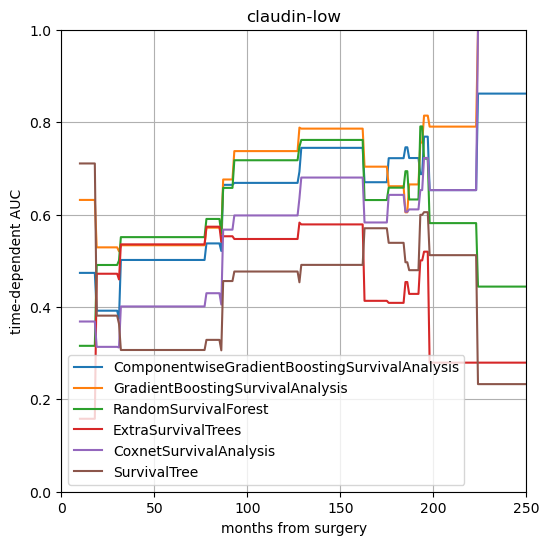

predict
[-0.39901437 -0.01712372  0.51199239 -0.33484165  0.30488025  0.50938021
 -0.18539784  0.54853374  0.02403635  0.05028422 -0.28040981  0.12921618
 -0.45566275  0.21633231  0.69511404 -0.30530981  0.32515246  0.1274136
  0.30177144 -0.2562319   0.44546743 -0.04832454 -0.61844262 -0.01670582
  0.68211748  0.00219539 -0.09452997  0.05800592  0.08203541  0.26575133
  0.52372206 -0.49694142  0.47051314 -0.38142415  0.20442521 -0.03912135
  0.00615399  0.02064286  0.20297299  0.281007    0.17350034  0.26237883
 -0.26908455 -0.32787212 -0.46472568 -0.02086339 -0.16150839 -0.06972772
 -0.28920915  0.10158899  0.2164218  -0.3874478  -0.21888973 -0.40239547
  0.33686026 -0.75718862 -0.08551776  0.14194453  0.44770165  0.25917064
  0.40155184 -0.91205814  0.29047484  0.22640354  0.35247924 -0.14467335
  0.05274178  0.51938739]
0.5780038830777998
predict
[ 0.19541946  0.80914078  1.5601087   0.80843095  0.08616679 -0.43528222
  1.83669764  1.23817427  0.18847491  0.43033844 -0.5609767  -0.

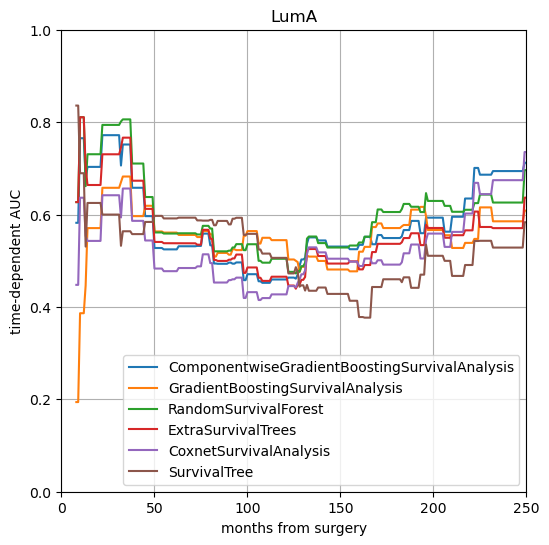

predict
[ 6.60289466e-01  1.20781336e-01  2.38131786e-01 -1.85577718e-01
  7.37163801e-01  3.71197888e-02 -2.72077370e-01  3.27219963e-01
 -1.33781953e-01 -3.59821254e-01  6.09954796e-01  9.47455986e-02
  2.99314524e-01 -2.69016194e-01 -2.76985198e-01 -3.57439431e-02
 -4.15349133e-01  8.23343789e-01 -2.72366709e-02 -3.93096602e-01
  4.09996907e-02 -1.69893296e-01  5.00957838e-01  2.49580893e-02
 -1.86597933e-01  2.01456118e-02 -3.47651200e-01  7.96965086e-03
 -5.38084756e-03  1.93149804e-01  4.60052915e-01 -3.46309832e-01
 -4.50666586e-02 -8.10018738e-01  4.68021166e-02 -5.15921087e-01
  2.24405804e-02 -1.90416046e-01  1.52339593e-01  6.17059632e-02
 -1.93695858e-01  4.27520563e-05  5.67991860e-01 -3.74056439e-01
 -1.89369440e-01  7.92125322e-01]
0.43815194913624744
predict
[ 1.7089343   0.24322647  0.54593136 -0.3806214   3.39404043 -0.01689762
 -0.81594364  0.69692346  0.8714959  -0.63764895  3.19431605  1.55713863
  1.95308527 -1.29193041 -0.43842126 -0.64142303  1.26519677  1.86453

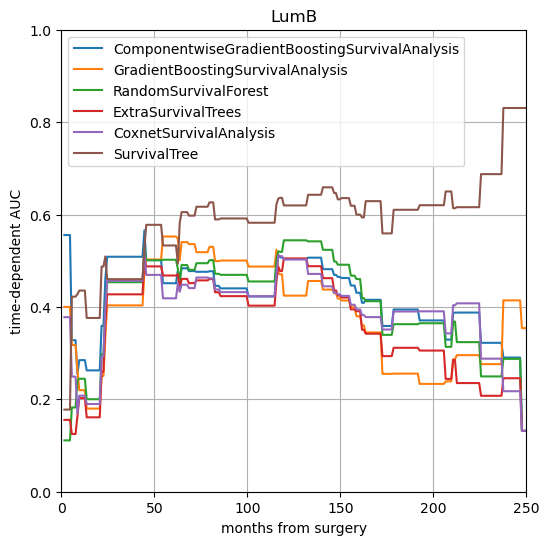

predict
[-0.06799254 -0.29720116  0.0206694   0.10226967 -0.11148894  0.24347086
  0.05703787  0.03927742 -0.11673327  0.11735333 -0.14007435 -0.11526117
 -0.00710106 -0.00443265 -0.04659134 -0.04189028  0.02590632  0.11736927
 -0.17553996  0.35970702  0.23187828  0.0918608 ]
0.49680226128965577
predict
[ 0.52294425 -4.9095443   1.48998354  2.87708233  1.36540203  0.24638987
  2.71241815  3.13207247 -1.32435694  3.082878   -1.3786273  -0.22464099
 -1.70435006 -0.20331345  1.5029529  -1.36797772  1.47861048  0.52424106
  0.24263354 -1.21018477  3.74150588  2.64843751]
0.44867640841973333
predict
[36.34082467 27.56896051 36.28749617 40.4229689  34.75667577 39.94495909
 41.29355721 45.84986227 28.17175312 42.03256964 22.96982441 31.34501603
 30.28802272 36.49092148 35.32613116 29.70067719 47.29452147 41.58182396
 37.23960986 42.16746095 45.75526428 50.66668244]
0.4489467537931276
predict
[34.55250989 33.12038552 34.29275279 35.17952398 34.36456955 36.27769623
 35.55337371 36.48052822 33.4

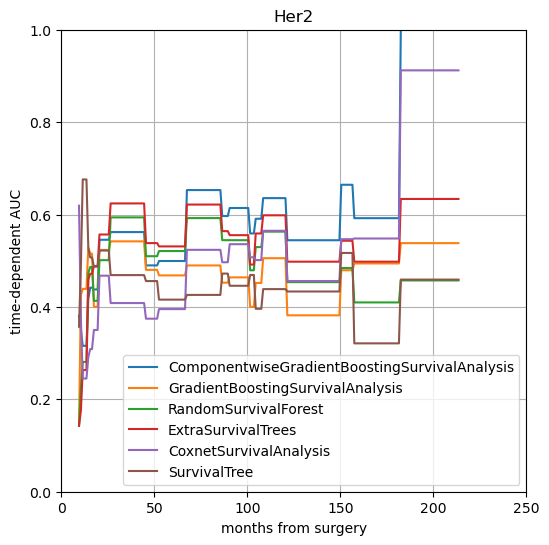

predict
[ 0.13813328  0.27840234  0.05544545  0.08151054  0.28379281 -0.01052031
  0.17124053  0.17438821  0.15168208  0.14558669  0.17746874  0.35901512
  0.84576868  0.26799449]
0.47334530078367537
predict
[ 4.6115392  -0.0135217  -1.9018876   0.73739061  2.30644691 -1.00212663
 -2.92476027 -3.13487188  1.03907859 -2.20110831  0.59100517  2.56795366
  3.8837051  -3.0701739 ]
0.7253123905883426
predict
[23.01591809 16.06689492 16.82344382 18.23574272 16.62219354 17.12564638
 16.61754949 11.73066872 22.54534327 16.47554954 16.66300081 19.61982662
 24.15063211 16.32040621]
0.7209660907983971
predict
[16.9187243  16.4801464  16.12107873 16.5763356  16.61743349 16.24111636
 16.63836952 16.21361483 16.76856893 16.40769906 16.47662708 16.64617024
 17.29572379 16.57351378]
0.6985098954782472
predict
[ 0.10535872  0.22918715 -0.03753657 -0.02006644  0.16655757  0.04224808
  0.12014719  0.1243797   0.20736487  0.07154144  0.13518239  0.31522416
  0.58298992  0.16489646]
0.5694349578677703
pred

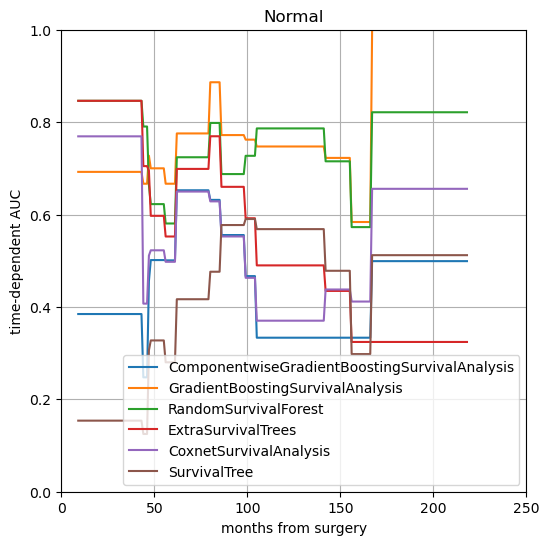

predict
[ 0.24695842  0.22239507  0.07582933  0.14209307  0.10167204  0.03497739
 -0.10675426 -0.01139443 -0.2176084   0.08070636  0.18700781 -0.08611383
 -0.06433331  0.04334036  0.05311969 -0.16172519 -0.39960522 -0.4391273
  0.23225498  0.45691346]
0.4328532226483815
predict
[ 2.44093318  0.27727508  2.20694596 -2.03748316 -3.33413659  0.14486529
 -0.45948898 -0.17075902 -1.88869909  1.48353054 -0.34117018  0.46214512
  0.32291425 -0.2416554   2.04516769  0.73390769  0.38722627 -1.84910574
  1.61549335  3.14578656]
0.22090579790638842
predict
[25.02850252 25.59412164 27.82362408 21.32383054 15.68818102 21.75914292
 21.00983248 20.09351263 15.59283938 31.66531846 25.30044687 25.6995579
 22.74561211 24.05480914 25.9898731  27.18801093 18.12286304 17.87357611
 24.51860197 26.83733608]
0.30475679411841317
predict
[21.31487967 21.65964039 21.60636939 21.31900225 20.02118144 21.24208937
 20.32613998 20.48121388 19.61673935 22.20448274 21.81316399 21.48692213
 20.38809574 20.95686852 21.00

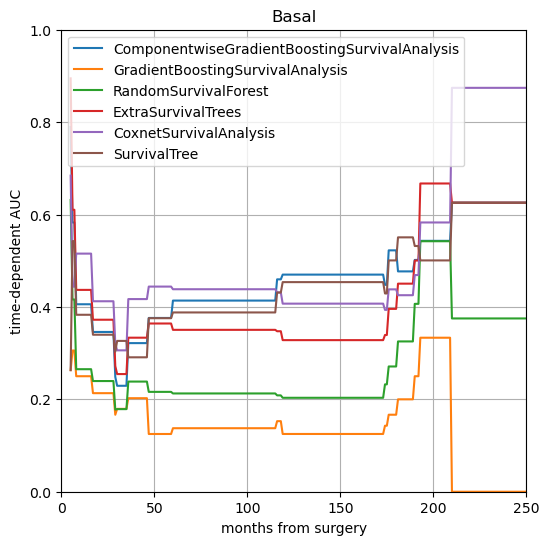

data pkl file dose not exist
data pkl file dose not exist
data pkl file dose not exist
data pkl file dose not exist
data pkl file dose not exist
data pkl file dose not exist


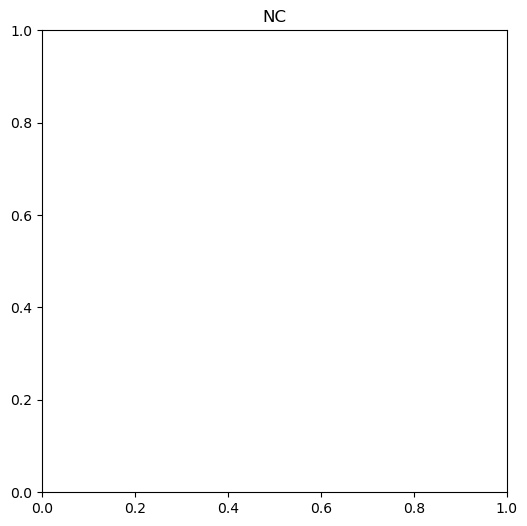

100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:22<00:00, 22.03s/it]


In [58]:
from sksurv.linear_model import CoxnetSurvivalAnalysis
from sksurv.tree import SurvivalTree

for p in tqdm(range(25, 26, 1)):
    print("++++++++++" * 10)
    print(p)
    PCA_PERCENTILE = p

    # 実施したい学習の定義
    model_order_dicts = [
        {
            "model_name": ComponentwiseGradientBoostingSurvivalAnalysis().__class__.__name__,
            "preprocess_name": "preprocess4numeric_pca{0}".format(PCA_PERCENTILE),
            "model_order": [
                (
                    ComponentwiseGradientBoostingSurvivalAnalysis().__class__.__name__,
                    ComponentwiseGradientBoostingSurvivalAnalysis(
                        n_estimators=1000,
                        random_state=config.SEED,
                    ),
                ),
            ],
        },
        {
            "model_name": GradientBoostingSurvivalAnalysis().__class__.__name__,
            "preprocess_name": "preprocess4numeric_pca{0}".format(PCA_PERCENTILE),
            "model_order": [
                (
                    GradientBoostingSurvivalAnalysis().__class__.__name__,
                    GradientBoostingSurvivalAnalysis(
                        n_estimators=1000,
                        random_state=config.SEED,
                    ),
                ),
            ],
        },
        {
            "model_name": RandomSurvivalForest().__class__.__name__,
            "preprocess_name": "preprocess4numeric_pca{0}".format(PCA_PERCENTILE),
            "model_order": [
                (
                    RandomSurvivalForest().__class__.__name__,
                    RandomSurvivalForest(
                        n_estimators=1000,
                        min_samples_split=10,
                        min_samples_leaf=15,
                        n_jobs=-1,
                        random_state=config.SEED,
                    ),
                ),
            ],
        },
        {
            "model_name": ExtraSurvivalTrees().__class__.__name__,
            "preprocess_name": "preprocess4numeric_pca{0}".format(PCA_PERCENTILE),
            "model_order": [
                (
                    ExtraSurvivalTrees().__class__.__name__,
                    ExtraSurvivalTrees(
                        random_state=config.SEED,
                        n_estimators=1000,
                        min_samples_split=10,
                        min_samples_leaf=15,
                        n_jobs=-1,
                    ),
                ),
            ],
        },
        {
            "model_name": CoxnetSurvivalAnalysis().__class__.__name__,
            "preprocess_name": "preprocess4numeric_pca{0}".format(PCA_PERCENTILE),
            "model_order": [
                (
                    CoxnetSurvivalAnalysis().__class__.__name__,
                    CoxnetSurvivalAnalysis(n_alphas=10000, fit_baseline_model=True),
                ),
            ],
        },
        {
            "model_name": SurvivalTree().__class__.__name__,
            "preprocess_name": "preprocess4numeric_pca{0}".format(PCA_PERCENTILE),
            "model_order": [
                (
                    SurvivalTree().__class__.__name__,
                    SurvivalTree(random_state=config.SEED),
                ),
            ],
        },
    ]
    loop_exec()

  0%|                                                                                             | 0/1 [00:00<?, ?it/s]

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
25
[-0.55392606 -2.17307399 -2.14325501 -1.71062237 -0.54244551 -0.71917419
 -2.11066187 -0.15097089 -2.64390978 -4.19852955 -1.66766981 -2.0720422
  3.18098817 -1.31175369  2.68214045 -3.00630389 -1.14435448 -0.53460374
  0.82514976  0.38638684]
0.6116986112883163


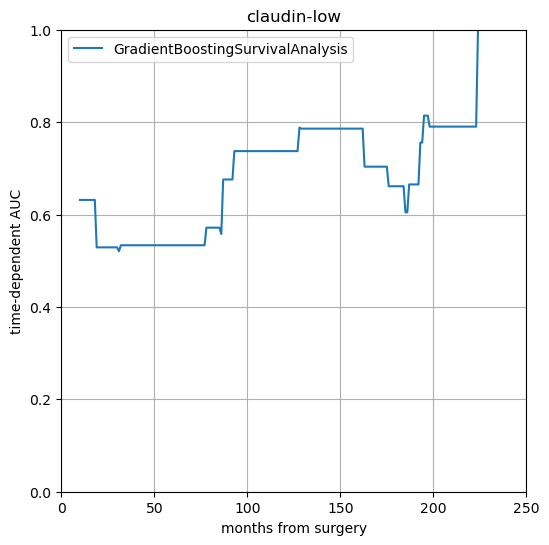

[ 0.19541946  0.80914078  1.5601087   0.80843095  0.08616679 -0.43528222
  1.83669764  1.23817427  0.18847491  0.43033844 -0.5609767  -0.67975299
 -0.26657809  0.31565547  1.93177952 -0.96848373  0.51452663 -0.73546514
 -0.05886456 -0.06131214  2.54955526 -0.66004949  0.46834071  0.53684635
  1.35504851  0.0870107   0.08419604  0.94013456  0.41769142  0.67799672
  0.79877928 -1.63634402  0.19139591 -1.43788871 -0.10832058  0.7431172
  1.20889405 -1.09765141 -0.41601722  0.57678195  0.17752406 -0.86798944
  0.18771741 -1.18609833 -1.67891038 -1.52293666 -0.41615825  2.00639048
  1.27683733 -1.02665062  1.19754968  0.89830563  0.16623252 -2.22867262
  1.82355893 -1.81274103  1.11873457  0.55078464  0.79998057  0.1313172
  0.16132316 -1.13021796  1.64380351  0.6519813   0.84440186 -0.60696194
 -0.00270837  0.45538819]
0.5408252951653412


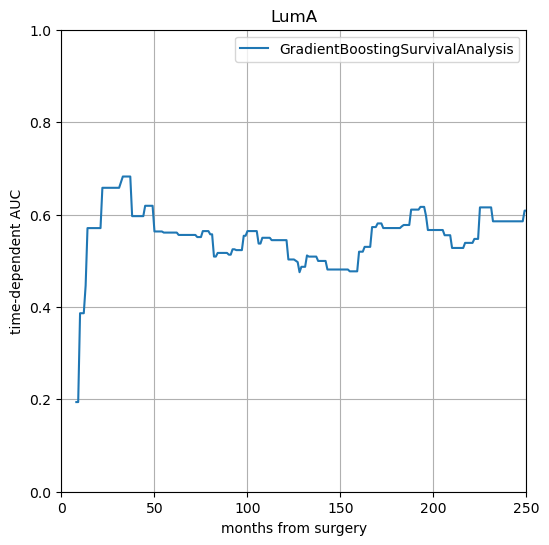

[ 1.7089343   0.24322647  0.54593136 -0.3806214   3.39404043 -0.01689762
 -0.81594364  0.69692346  0.8714959  -0.63764895  3.19431605  1.55713863
  1.95308527 -1.29193041 -0.43842126 -0.64142303  1.26519677  1.86453457
  0.54085743 -1.10163519  2.1798017  -1.70260001 -1.62456366  0.24756196
 -0.41070178 -0.54439415 -0.8636818  -1.40495678  1.07604191 -0.18852409
  5.85458892  0.44682677 -1.10355111 -2.77102741  1.52564725 -1.16564574
 -0.30866059  0.46124338  2.31521451  3.66652901 -0.42050691 -0.39467067
  1.05402675  2.31922454  0.13202664  1.58504967]
0.4092811571418076


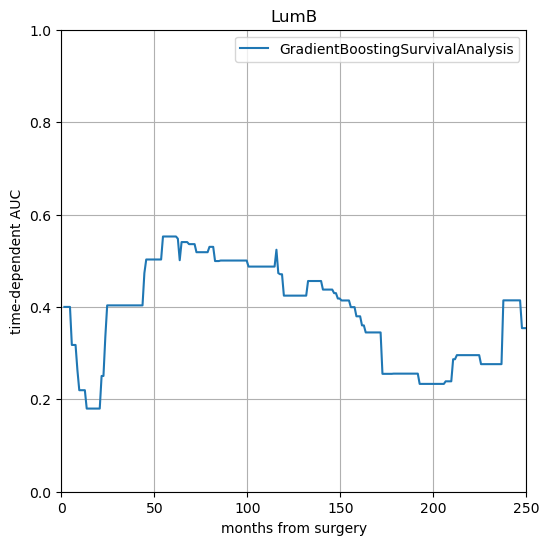

[ 0.52294425 -4.9095443   1.48998354  2.87708233  1.36540203  0.24638987
  2.71241815  3.13207247 -1.32435694  3.082878   -1.3786273  -0.22464099
 -1.70435006 -0.20331345  1.5029529  -1.36797772  1.47861048  0.52424106
  0.24263354 -1.21018477  3.74150588  2.64843751]
0.44867640841973333


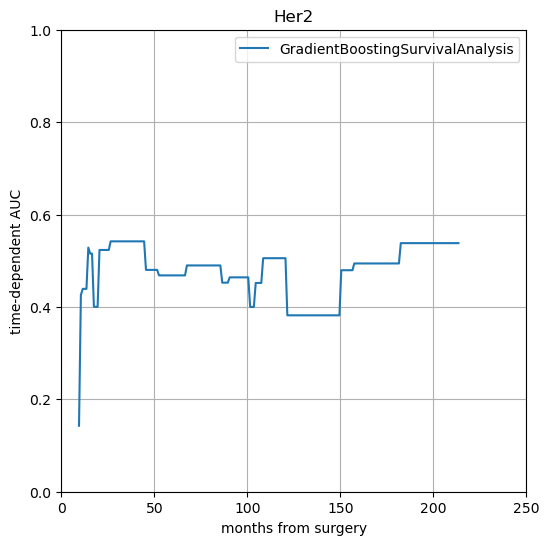

[ 4.6115392  -0.0135217  -1.9018876   0.73739061  2.30644691 -1.00212663
 -2.92476027 -3.13487188  1.03907859 -2.20110831  0.59100517  2.56795366
  3.8837051  -3.0701739 ]
0.7253123905883426


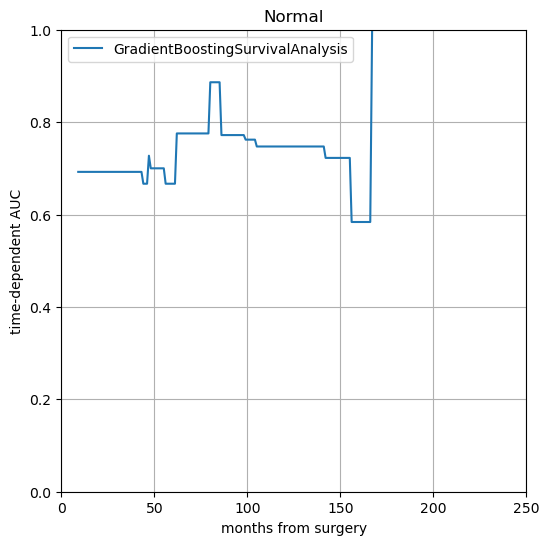

[ 2.44093318  0.27727508  2.20694596 -2.03748316 -3.33413659  0.14486529
 -0.45948898 -0.17075902 -1.88869909  1.48353054 -0.34117018  0.46214512
  0.32291425 -0.2416554   2.04516769  0.73390769  0.38722627 -1.84910574
  1.61549335  3.14578656]
0.22090579790638842


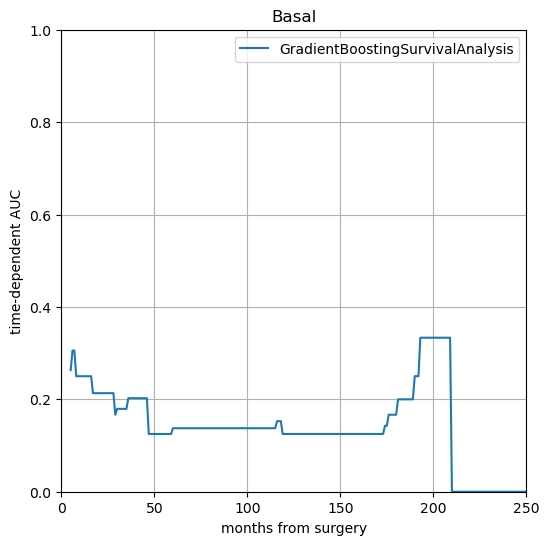

data pkl file dose not exist


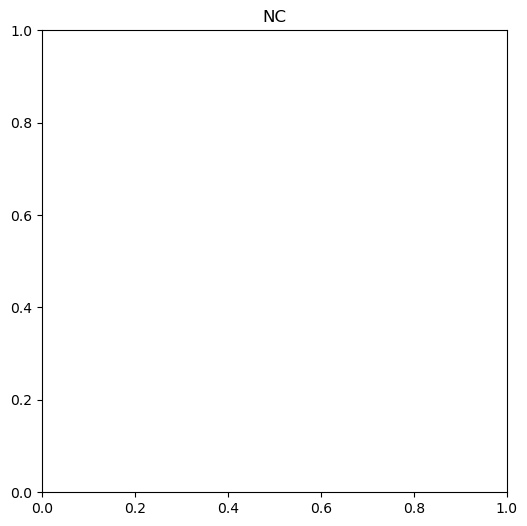

100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:10<00:00, 10.23s/it]


In [75]:
from sksurv.linear_model import CoxnetSurvivalAnalysis
from sksurv.tree import SurvivalTree

for p in tqdm(range(25, 26, 1)):
    print("++++++++++" * 10)
    print(p)
    PCA_PERCENTILE = p

    # 実施したい学習の定義
    model_order_dicts = [
        {
            "model_name": GradientBoostingSurvivalAnalysis().__class__.__name__ + "_2",
            "preprocess_name": "preprocess4numeric_pca{0}".format(PCA_PERCENTILE),
            "model_order": [
                (
                    GradientBoostingSurvivalAnalysis().__class__.__name__,
                    GradientBoostingSurvivalAnalysis(
                        n_estimators=1000,
                        random_state=config.SEED,
                    ),
                ),
            ],
        },
    ]
    loop_exec()

In [14]:
data_path = (
    config.INTERIM_PREPROCESSED_RECURRENCE_DIR
    + "/CLAUDIN_SUBTYPE/claudin-low/preprocess4numeric_pca25/test_set/test/X.pkl"
)

X = pd.read_pickle(data_path)

pipe_path = (
    config.INTERIM_MODELS_RECURRENCE_DIR
    + "/CLAUDIN_SUBTYPE/claudin-low/preprocess4numeric_pca25/ComponentwiseGradientBoostingSurvivalAnalysis/test_set/model_pipeline.pkl"
)
pipe = pd.read_pickle(pipe_path)

In [15]:
X.shape

(20, 7)

In [39]:
print("LumA")
pipe_path = (
    config.INTERIM_PREPROCESSED_RECURRENCE_DIR
    + "/CLAUDIN_SUBTYPE/LumA/preprocess4numeric_pca25/test_set/test/preprocess_pipeline.pkl"
)
pipe = pd.read_pickle(pipe_path)
display(pipe[-1].explained_variance_ratio_)

print("LumB")
pipe_path = (
    config.INTERIM_PREPROCESSED_RECURRENCE_DIR
    + "/CLAUDIN_SUBTYPE/LumB/preprocess4numeric_pca25/test_set/test/preprocess_pipeline.pkl"
)
pipe = pd.read_pickle(pipe_path)
display(pipe[-1].explained_variance_ratio_)

print("Her2")
pipe_path = (
    config.INTERIM_PREPROCESSED_RECURRENCE_DIR
    + "/CLAUDIN_SUBTYPE/Her2/preprocess4numeric_pca25/test_set/test/preprocess_pipeline.pkl"
)
pipe = pd.read_pickle(pipe_path)
display(pipe[-1].explained_variance_ratio_)


print("claudin-low")
pipe_path = (
    config.INTERIM_PREPROCESSED_RECURRENCE_DIR
    + "/CLAUDIN_SUBTYPE/claudin-low/preprocess4numeric_pca25/test_set/test/preprocess_pipeline.pkl"
)
pipe = pd.read_pickle(pipe_path)
display(pipe[-1].explained_variance_ratio_)

print("Basal")
pipe_path = (
    config.INTERIM_PREPROCESSED_RECURRENCE_DIR
    + "/CLAUDIN_SUBTYPE/Basal/preprocess4numeric_pca25/test_set/test/preprocess_pipeline.pkl"
)
pipe = pd.read_pickle(pipe_path)
display(pipe[-1].explained_variance_ratio_)

LumA


array([0.06759091, 0.02905811, 0.02722057, 0.02326645, 0.01788881,
       0.01607798, 0.01544472, 0.01369309, 0.01257344, 0.01137555,
       0.01045657, 0.00933435])

LumB


array([0.06170837, 0.03092133, 0.02477504, 0.02279344, 0.0214198 ,
       0.01828258, 0.01507577, 0.01349014, 0.01168162, 0.01090742,
       0.00999922, 0.00925634])

Her2


array([0.11797141, 0.02742829, 0.02581782, 0.022775  , 0.01953257,
       0.01871846, 0.01655606, 0.01490701])

claudin-low


array([0.06212068, 0.05251039, 0.04030487, 0.03063363, 0.02981145,
       0.02574706, 0.02031933])

Basal


array([0.07083228, 0.03908621, 0.03263769, 0.0232195 , 0.02014028,
       0.01881794, 0.01745214, 0.01481924, 0.0144878 ])

In [42]:
print("25")
pipe_path = (
    config.INTERIM_PREPROCESSED_RECURRENCE_DIR
    + "/CLAUDIN_SUBTYPE/LumB/preprocess4numeric_pca25/test_set/test/preprocess_pipeline.pkl"
)
pipe = pd.read_pickle(pipe_path)
display(pipe[-1].explained_variance_ratio_)

print("50")
pipe_path = (
    config.INTERIM_PREPROCESSED_RECURRENCE_DIR
    + "/CLAUDIN_SUBTYPE/LumB/preprocess4numeric_pca50/test_set/test/preprocess_pipeline.pkl"
)
pipe = pd.read_pickle(pipe_path)
display(pipe[-1].explained_variance_ratio_)

print("77")
pipe_path = (
    config.INTERIM_PREPROCESSED_RECURRENCE_DIR
    + "/CLAUDIN_SUBTYPE/LumB/preprocess4numeric_pca75/test_set/test/preprocess_pipeline.pkl"
)
pipe = pd.read_pickle(pipe_path)
display(pipe[-1].explained_variance_ratio_)

25


array([0.06170837, 0.03092133, 0.02477504, 0.02279344, 0.0214198 ,
       0.01828258, 0.01507577, 0.01349014, 0.01168162, 0.01090742,
       0.00999922, 0.00925634])

50


array([0.06170837, 0.03092133, 0.02477504, 0.02279344, 0.0214198 ,
       0.01828258, 0.01507577, 0.01349014, 0.01168162, 0.01090742,
       0.00999922, 0.00925634, 0.00855016, 0.0080839 , 0.00732914,
       0.00678117, 0.00661235, 0.00642354, 0.00607306, 0.00581754,
       0.00568891, 0.00543384, 0.00536093, 0.0051921 , 0.00504523,
       0.00491971, 0.004789  , 0.00470871, 0.00447032, 0.00434198,
       0.00429739, 0.0042598 , 0.00424111, 0.00405216, 0.00403754,
       0.00390322, 0.00385149, 0.00379399, 0.00372488, 0.00368345,
       0.00359929, 0.00353789, 0.00348648, 0.00342632, 0.00340937,
       0.00336435, 0.00328004, 0.00325228, 0.00321191, 0.00317308,
       0.00313151, 0.00308002, 0.00304576, 0.00302505, 0.00298507,
       0.00293087, 0.0029094 , 0.00290488, 0.00288722, 0.00286625,
       0.00282225, 0.00278126, 0.00277405, 0.00271213, 0.00270363,
       0.00268753, 0.00266633, 0.0026572 , 0.00264854, 0.00260518,
       0.00259679, 0.00256976, 0.00255093, 0.0025262 , 0.00250

77


array([0.06170837, 0.03092133, 0.02477504, 0.02279344, 0.0214198 ,
       0.01828258, 0.01507577, 0.01349014, 0.01168162, 0.01090742,
       0.00999922, 0.00925634, 0.00855016, 0.0080839 , 0.00732914,
       0.00678117, 0.00661235, 0.00642354, 0.00607306, 0.00581754,
       0.00568891, 0.00543384, 0.00536093, 0.0051921 , 0.00504523,
       0.00491971, 0.004789  , 0.00470871, 0.00447032, 0.00434198,
       0.00429739, 0.0042598 , 0.00424111, 0.00405216, 0.00403754,
       0.00390322, 0.00385149, 0.00379399, 0.00372488, 0.00368345,
       0.00359929, 0.00353789, 0.00348648, 0.00342632, 0.00340937,
       0.00336435, 0.00328004, 0.00325228, 0.00321191, 0.00317308,
       0.00313151, 0.00308002, 0.00304576, 0.00302505, 0.00298507,
       0.00293087, 0.0029094 , 0.00290488, 0.00288722, 0.00286625,
       0.00282225, 0.00278126, 0.00277405, 0.00271213, 0.00270363,
       0.00268753, 0.00266633, 0.0026572 , 0.00264854, 0.00260518,
       0.00259679, 0.00256976, 0.00255093, 0.0025262 , 0.00250

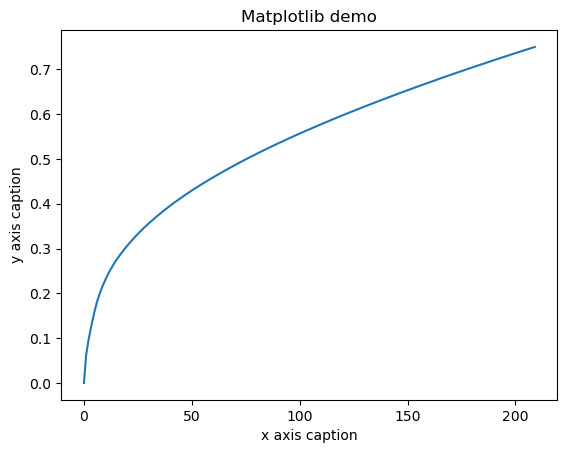

In [55]:
x = np.arange(0, len(pipe[-1].explained_variance_ratio_))
y = pipe[-1].explained_variance_ratio_
plt.title("Matplotlib demo")
plt.xlabel("x axis caption")
plt.ylabel("y axis caption")
# plt.plot(x, y)
plt.plot([0] + list(np.cumsum(y)), "-")
plt.show()